<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/1-the-machine-learning-landscape/instance_based_versus_model_based_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance-Based Versus Model-Based Learning

**One more way to categorize Machine Learning systems is by how they generalize.** Most Machine Learning tasks are about making predictions. This means that given a number of training examples, the system needs to be able to make good predictions for (generalize to) examples it has never seen before. **Having a good performance measure on the training data is good, but insufficient; the true goal is to perform well on new instances.**

There are two main approaches to generalization: 
* **Instance-based learning**
* **Model-based learning**

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

import os
import urllib

%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

This function just merges the OECD's life satisfaction data and the IMF's GDP per capita data.

In [0]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [0]:
datapath = os.path.join("datasets", "lifesat", "")

In [5]:
# Download the data
DOWNLOAD_ROOT  = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
os.makedirs(datapath, exist_ok=True)

for filename in ('oecd_bli_2015.csv', 'gdp_per_capita.csv'):
  print(f'Downloading {filename}')
  url = DOWNLOAD_ROOT + 'datasets/lifesat/' + filename
  urllib.request.urlretrieve(url, datapath + filename)

### Load and prepare Life satisfaction data

In [6]:
oecd_bli = pd.read_csv(datapath + 'oecd_bli_2015.csv', thousands=',')
oecd_bli = oecd_bli[oecd_bli['INEQUALITY']=='TOT']
oecd_bli = oecd_bli.pivot(index='Country', columns='Indicator', values='Value')
oecd_bli.head()

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,20.0,4.8,82.1,7.3,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,21.0,3.9,81.0,6.9,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,21.0,5.0,80.5,6.9,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,21.0,6.4,81.5,7.3,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2


In [7]:
oecd_bli['Life satisfaction'].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

### Load and prepare GDP per capita data

In [8]:
gdp_per_capita = pd.read_csv(datapath + 'gdp_per_capita.csv', thousands=',', delimiter='\t', encoding='latin1', na_values='n/a')
gdp_per_capita.rename(columns={'2015': 'GDP per capita'}, inplace=True)
gdp_per_capita.set_index('Country', inplace=True)
gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


### Merging Life satisfaction and GDP per capita dataset

In [10]:
(oecd_bli.shape, gdp_per_capita.shape)

((37, 24), (190, 6))

In [11]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by='GDP per capita', inplace=True)
full_country_stats.shape

(36, 30)

In [12]:
full_country_stats.head()

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,21.0,4.9,74.6,6.7,0.08,16193.0,77.0,1.0,66.0,417.0,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,11.0,4.0,70.2,6.0,1.70,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9054.914,2015.0
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,21.0,8.1,74.6,5.6,2.37,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9437.372,2013.0
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,20.0,5.7,75.2,4.9,5.10,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12239.894,2015.0


In [13]:
# check the one country data
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States"]

GDP per capita       55805.204
Life satisfaction        7.200
Name: United States, dtype: float64

In [0]:
# consider only two features
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

## Instance-based learning

**Possibly the most trivial form of learning is simply to learn by heart**. If you were to create a spam filter this way, it would just flag all emails that are identical to emails that have already been flagged by users—**not the worst solution, but certainly not the best.**

Instead of just flagging emails that are identical to known spam emails, your spam filter could be programmed to also flag emails that are very similar to known spam emails. **This requires a measure of similarity between two emails. A (very basic) similarity measure between two emails could be to count the number of words they have in common.** The system would flag an email as spam if it has many words in common with a known spam email.

**This is called instance-based learning: the system learns the examples by heart, then generalizes to new cases by using a similarity measure to compare them to the learned examples (or a subset of them).**

For example, the new instance would be classified as a triangle because the majority of the most similar instances belong to that class.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/instance-based-learning.png?raw=1' width='800'/>

## Model-based learning

**Another way to generalize from a set of examples is to build a model of these examples and then use that model to make predictions. This is called model-based learning.**

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/model-based-learning.png?raw=1' width='800'/>

For example, suppose you want to know if money makes people happy, so you download the Better Life Index data from the [OECD’s website](https://stats.oecd.org/index.aspx?DataSetCode=BLI) and stats about gross domestic product (GDP) per capita from the [IMF’s website](https://homl.info/5). Then you join the tables and sort by GDP per capita.

|Country|GDP per capita(USD)|Life satisfaction|
|-------|-------------------|-----------------|
|Hungary|12,240|4.9|
|Korea|27,195|5.8|
|France|37,675|6.5|
|Australia|50,962|7.3|
|United States|55,805|7.2|


Let’s plot the data for these countries.

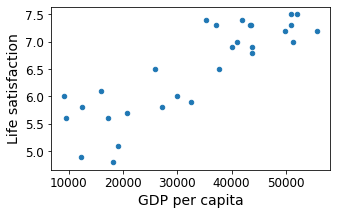

In [16]:
sample_data.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', figsize=(5, 3))

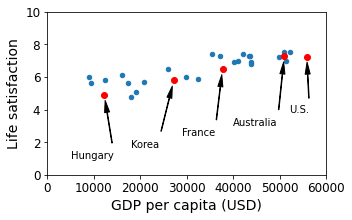

In [21]:
sample_data.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', figsize=(5, 3))
plt.axis([0, 60000, 0, 10])
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}

for country, pos_text in position_text.items():
  pos_data_x, pos_data_y = sample_data.loc[country]
  country = 'U.S.' if country == 'United States' else country
  plt.annotate(country, xy=(pos_data_x,pos_data_y), xytext=pos_text, arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
  plt.plot(pos_data_x, pos_data_y, 'ro')
plt.xlabel('GDP per capita (USD)')
plt.show()

There does seem to be a trend here! Although the data is noisy (i.e., partly random), it looks like life satisfaction goes up more or less linearly as the country’s GDP per capita increases. **So you decide to model life satisfaction as a linear function of GDP per capita. This step is called model selection: you selected a linear model of life satisfaction with just one attribute, GDP per capita.**

$$life-satisfaction = θ_0 + θ_1 × GDP-per-capita$$

**This model has two model parameters, $θ_0$ and $θ_1$. By tweaking these parameters, you can make your model represent any linear function.**

In [22]:
sample_data.to_csv(os.path.join('datasets', 'lifesat', 'lifesat.csv'))
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


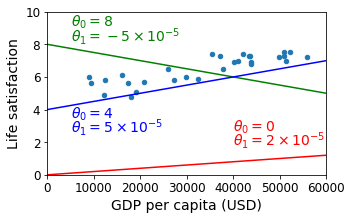

In [23]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

**Before you can use your model, you need to define the parameter values $θ_0$ and $θ_1$.**

How can you know which values will make your model perform best? 

To answer this question, you need to specify a performance measure. You can either define a utility function (or fitness function) that measures how good your model is, or you can define **a cost function that measures how bad it is. For Linear Regression problems, people typically use a cost function that measures the distance between the linear model’s predictions and the training examples; the objective is to minimize this distance.**

This is where the Linear Regression algorithm comes in: **you feed it your training examples, and it finds the parameters that make the linear model fit best to your data.** This is called training the model. In our case, the algorithm finds that the optimal parameter values are $$θ_0 = 4.85$$
$$θ_1 = 4.91 × 10^{-5}$$

---

Confusingly, the same word “model” can refer to a type of model
(e.g., Linear Regression), to a fully specified model architecture (e.g.,
Linear Regression with one input and one output), or to the final
trained model ready to be used for predictions (e.g., Linear Regression
with one input and one output, using $θ_0 = 4.85$ and $θ_1 = 4.91 ×
10^{–5}$). 

**Model selection consists in choosing the type of model and
fully specifying its architecture.** 

**Training a model means running an algorithm to find the model parameters that will make it best fit the training data (and hopefully make good predictions on new data).**


---



In [27]:
lin_model = linear_model.LinearRegression()

Xsample = np.c_[sample_data['GDP per capita']]
ysample = np.c_[sample_data['Life satisfaction']]

lin_model.fit(Xsample, ysample)

t0, t1 = lin_model.intercept_[0], lin_model.coef_[0][0]
t0, t1

(4.853052800266436, 4.911544589158484e-05)

Now the model fits the training data as closely as possible (for a linear model).

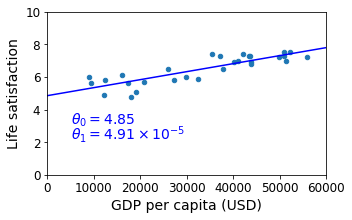

In [28]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

**You are finally ready to run the model to make predictions**. 

For example, say **you want to know how happy Cypriots are, and the OECD data does not have the answer.**
Fortunately, you can use your model to make a good prediction: you look up Cyprus’s GDP per capita, find $22,587, and then apply your model and find that life satisfaction is likely to be somewhere around 4.85 + 22,587 × 4.91 × 10^-5 = 5.96.

In [29]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)
cyprus_predicted_life_satisfaction = lin_model.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

22587.49


5.96244744318815

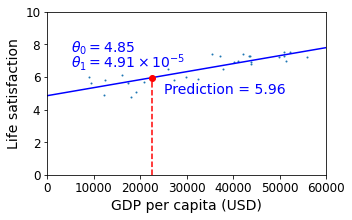

In [30]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")

plt.show()

## Training a linear model using Scikit-Learn

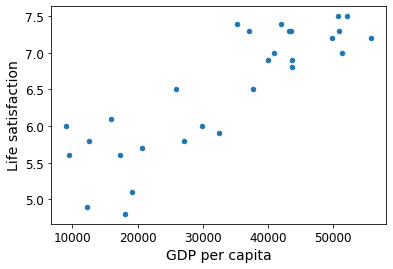

In [32]:
# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t', encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats['GDP per capita']]
y = np.c_[country_stats['Life satisfaction']]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

In [34]:
# create linear model
model = linear_model.LinearRegression()

# train the model
model.fit(X, y)

# make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(model.predict(X_new))

[[5.96242338]]


## Training a k-Nearest Neighbors regression using Scikit-Learn

If you had used an instance-based learning algorithm instead, you
would have found that Slovenia has the closest GDP per capita to
that of Cyprus ($20,732), and since the OECD data tells us that
Slovenians’ life satisfaction is 5.7, you would have predicted a life
satisfaction of 5.7 for Cyprus. 

If you zoom out a bit and look at the two next-closest countries, you will find Portugal and Spain with life satisfactions of 5.1 and 6.5, respectively. 

In [35]:
sample_data[7:10]

,GDP per capita,Life satisfaction
Country,,
Portugal,19121.592,5.1
Slovenia,20732.482,5.7
Spain,25864.721,6.5


Averaging these three values, you get 5.77, which is pretty close to your model-based prediction. This simple algorithm is called k-Nearest Neighbors regression (in this example, k = 3).

In [36]:
(5.1+5.7+6.5)/3

5.766666666666667

In [41]:
import sklearn.neighbors

kmodel = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

# train the model
kmodel.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [42]:
# make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(kmodel.predict(X_new))

[[5.76666667]]


## Conclusion

Since in instance-based learning: **the system learns the examples by heart, then generalizes to new cases by using a similarity measure to compare them to the learned examples (or a subset of them)**. It means, **during prediction time it does compare all training example one-by-one so there is very poor performnace and it takes time during prediction.**

And in model-based learning: **to generalize from a set of examples, first of all there is a need to build a model of these examples and then use that model to make predictions**.It means, **during prediction time it does not compare all training example one-by-one so there is very good performnace and it does not take time during prediction.**